## Data Loading and Initial Challenges
Initially, we faced a challenge fetching the dataset directly using the `ucimlrepo` library due to server-side connectivity issues.

To overcome this, we adopted an alternative approach by manually downloading the `chronic_kidney_disease_full.arff` file. We then implemented a custom parsing script, adapted from a solution on [Stack Overflow](https://stackoverflow.com/questions/62653514/open-an-arff-file-with-scipy-io/66939746#66939746), to load the data into a pandas DataFrame.

The script reads the .arff file line by line, skipping the header metadata and using a predefined list of column names to structure the data correctly. The code for this process is as follows:

In [246]:
import pandas as pd

data = []
with open('kidney/chronic_kidney_disease_full.arff', "r") as f:
    for line in f:
        line = line.replace('\n', '')
        data.append(line.split(','))


names = ['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba',
         'bgr', 'bu',  'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc',
         'rbcc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane',
         'class', 'no_name']

df = pd.DataFrame(data[145:], columns=names)
df.describe()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class,no_name
count,402,400,400,400,400,400,400,400,400,400,...,400,400,400,400,400,400,400,400,400,3
unique,78,11,6,7,7,3,3,3,3,147,...,93,50,3,7,4,4,4,3,4,2
top,60,80,1.020,0,0,normal,normal,notpresent,notpresent,?,...,?,?,no,no,no,good,no,no,ckd,
freq,19,116,106,199,290,201,259,354,374,44,...,105,130,251,257,362,316,322,339,248,2


## Feature Selection and Data Type Conversion

Our manual loading method didn't preserve the original data types, however, this was not a significant issue, as our plan from the start was to focus mainly on the numeric features for this analysis.

In [247]:
df.dtypes

age        object
bp         object
sg         object
al         object
su         object
rbc        object
pc         object
pcc        object
ba         object
bgr        object
bu         object
sc         object
sod        object
pot        object
hemo       object
pcv        object
wbcc       object
rbcc       object
htn        object
dm         object
cad        object
appet      object
pe         object
ane        object
class      object
no_name    object
dtype: object


First, we will drop the categorical columns that aren't needed for this analysis. Then, we'll convert the remaining columns using the to_numeric function in pandas. We use the errors='coerce' setting, which is very helpful because it automatically turns any value that can't be converted (like a leftover symbol or text) into NaN (Not a Number). This makes the entire dataset consistent and easier to clean in the next steps.

#### 1. Feature Selection: Drop unnecessary categorical and identifier columns

In [248]:
df = df.drop(columns=[
    'no_name', 'rbc', 'pc', 'pcc', 'ba',
    'sc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane'
])

#### 2. Data Type Conversion: Define which columns should be numeric

In [249]:
numeric_cols = ['age', 'bp', 'sg', 'al', 'su',
                'bgr', 'bu', 'sod', 'pot', 'hemo',
                'pcv', 'wbcc', 'rbcc']

# Loop through the list and convert each column
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

#### 3. Verification: Display the final data types to confirm the conversion

In [250]:
df.dtypes

age      float64
bp       float64
sg       float64
al       float64
su       float64
bgr      float64
bu       float64
sod      float64
pot      float64
hemo     float64
pcv      float64
wbcc     float64
rbcc     float64
class     object
dtype: object

## Data cleaning

After loading and formatting the data, the next critical phase is data cleaning. The primary goals for this stage are to handle the missing values, simplify the class column for modeling, and identify any potential outliers that could affect the results.

Our cleaning process consists of the following steps:
#### 1. Standardize Missing Values
Ensure all placeholders are consistently represented as `NaN`.

In [251]:
# Note: pd.to_numeric with errors='coerce' already handled most of this.
# This is an extra step to ensure consistency.
df = df.replace(['?', 'None'], pd.NA)

#### 2. Handle Rows with Missing Data:
Remove rows that have an excessive number of missing values (3 or more), as they are unlikely to be useful.

In [252]:
df = df.dropna(thresh=len(df.columns)-2)
df = df.reset_index(drop=True)

#### 3. Impute Remaining Missing Values:
Fill the few remaining NaNs in the numeric columns. We will use the mean of each column for this.

In [253]:
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].mean()).round(3)

#### 4. Encode the Target Variable:
Simplify the class column into two distinct categories for our analysis.

In [254]:
#Changing ckd --> a (affected), notckd && no --> c (control)
df['class'] = df['class'].replace({'ckd': 'a', 'notckd': 'c', 'no': 'c'})

# Display the first few rows of the cleaned DataFrame
print("DataFrame after cleaning and imputation:")
display(df.head())

DataFrame after cleaning and imputation:


,age,bp,sg,al,su,bgr,bu,sod,pot,hemo,pcv,wbcc,rbcc,class
0,48.0,80.0,1.020,1.0,0.0,121.0,36.0,138.193,4.52,15.4,44.0,7800.000,5.200,a
1,48.0,70.0,1.005,4.0,0.0,117.0,56.0,111.000,2.50,11.2,32.0,6700.000,3.900,a
2,51.0,80.0,1.010,2.0,0.0,106.0,26.0,138.193,4.52,11.6,35.0,7300.000,4.600,a
3,60.0,90.0,1.015,3.0,0.0,74.0,25.0,142.000,3.20,12.2,39.0,7800.000,4.400,a
4,68.0,70.0,1.010,0.0,0.0,100.0,54.0,104.000,4.00,12.4,36.0,8498.795,4.759,a


#### Verify that there are no missing values left

In [255]:
print("\nTotal missing values per column after cleaning:")
print(df.isnull().sum())


Total missing values per column after cleaning:
age      0
bp       0
sg       0
al       0
su       0
bgr      0
bu       0
sod      0
pot      0
hemo     0
pcv      0
wbcc     0
rbcc     0
class    0
dtype: int64


In [256]:
#Muutetaan hemoglobiini g/dl --> g/l
df['hemo'] = pd.to_numeric(df['hemo'], errors='coerce') * 10
df

,age,bp,sg,al,su,bgr,bu,sod,pot,hemo,pcv,wbcc,rbcc,class
0,48.0,80.0,1.020,1.0,0.0,121.0,36.0,138.193,4.52,154.0,44.0,7800.000,5.200,a
1,48.0,70.0,1.005,4.0,0.0,117.0,56.0,111.000,2.50,112.0,32.0,6700.000,3.900,a
2,51.0,80.0,1.010,2.0,0.0,106.0,26.0,138.193,4.52,116.0,35.0,7300.000,4.600,a
3,60.0,90.0,1.015,3.0,0.0,74.0,25.0,142.000,3.20,122.0,39.0,7800.000,4.400,a
4,68.0,70.0,1.010,0.0,0.0,100.0,54.0,104.000,4.00,124.0,36.0,8498.795,4.759,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,55.0,80.0,1.020,0.0,0.0,140.0,49.0,150.000,4.90,157.0,47.0,6700.000,4.900,c
261,42.0,70.0,1.025,0.0,0.0,75.0,31.0,141.000,3.50,165.0,54.0,7800.000,6.200,c
262,12.0,80.0,1.020,0.0,0.0,100.0,26.0,137.000,4.40,158.0,49.0,6600.000,5.400,c
263,17.0,60.0,1.025,0.0,0.0,114.0,50.0,135.000,4.90,142.0,51.0,7200.000,5.900,c


In [257]:
#jaetaan kahdeen dataframeen classin perusteella
df_a = df[df['class'] == 'a']
df_c = df[df['class'] == 'c']

#a:n ja c:n rivimäärät
print("Affected (a):", df_a.shape[0], "rows")
print("Control (c):", df_c.shape[0], "rows")


Affected (a): 126 rows
Control (c): 139 rows


In [258]:
#Näytä dataframe 'a'
df_a

,age,bp,sg,al,su,bgr,bu,sod,pot,hemo,pcv,wbcc,rbcc,class
0,48.0,80.0,1.020,1.0,0.0,121.0,36.0,138.193,4.52,154.0,44.0,7800.000,5.200,a
1,48.0,70.0,1.005,4.0,0.0,117.0,56.0,111.000,2.50,112.0,32.0,6700.000,3.900,a
2,51.0,80.0,1.010,2.0,0.0,106.0,26.0,138.193,4.52,116.0,35.0,7300.000,4.600,a
3,60.0,90.0,1.015,3.0,0.0,74.0,25.0,142.000,3.20,122.0,39.0,7800.000,4.400,a
4,68.0,70.0,1.010,0.0,0.0,100.0,54.0,104.000,4.00,124.0,36.0,8498.795,4.759,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,62.0,90.0,1.020,2.0,1.0,169.0,48.0,138.000,2.90,134.0,47.0,11000.000,6.100,a
122,64.0,90.0,1.015,3.0,2.0,463.0,64.0,135.000,4.10,122.0,40.0,9800.000,4.600,a
123,48.0,110.0,1.015,3.0,0.0,106.0,215.0,120.000,5.70,86.0,26.0,5000.000,2.500,a
124,59.0,70.0,1.010,1.0,3.0,424.0,55.0,138.000,4.50,126.0,37.0,10200.000,4.100,a


In [259]:
#Näytä dataframe 'c'
df_c

,age,bp,sg,al,su,bgr,bu,sod,pot,hemo,pcv,wbcc,rbcc,class
126,40.0,80.0,1.025,0.0,0.0,140.0,10.0,135.0,5.0,150.0,48.0,10400.0,4.5,c
127,23.0,80.0,1.025,0.0,0.0,70.0,36.0,150.0,4.6,170.0,52.0,9800.0,5.0,c
128,45.0,80.0,1.025,0.0,0.0,82.0,49.0,147.0,4.4,159.0,46.0,9100.0,4.7,c
129,57.0,80.0,1.025,0.0,0.0,119.0,17.0,135.0,4.7,154.0,42.0,6200.0,6.2,c
130,51.0,60.0,1.025,0.0,0.0,99.0,38.0,135.0,3.7,130.0,49.0,8300.0,5.2,c
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,55.0,80.0,1.020,0.0,0.0,140.0,49.0,150.0,4.9,157.0,47.0,6700.0,4.9,c
261,42.0,70.0,1.025,0.0,0.0,75.0,31.0,141.0,3.5,165.0,54.0,7800.0,6.2,c
262,12.0,80.0,1.020,0.0,0.0,100.0,26.0,137.0,4.4,158.0,49.0,6600.0,5.4,c
263,17.0,60.0,1.025,0.0,0.0,114.0,50.0,135.0,4.9,142.0,51.0,7200.0,5.9,c


In [260]:
#Näyttää dataframe "a" jokaisen sarakkeen perusstatistiikat
df_a.describe()

,age,bp,sg,al,su,bgr,bu,sod,pot,hemo,pcv,wbcc,rbcc
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,56.948508,80.680968,1.013595,1.849206,0.809524,179.339143,80.224071,134.368841,4.718730,106.620635,32.497492,9352.256627,4.088587
std,14.315945,15.712210,0.004526,1.437038,1.366539,91.658210,60.298976,7.264335,3.890027,21.911295,7.151425,3533.656472,0.828254
min,6.000000,50.000000,1.005000,0.000000,0.000000,22.000000,1.500000,104.000000,2.500000,31.000000,9.000000,2600.000000,2.100000
25%,50.000000,70.000000,1.010000,0.250000,0.000000,108.250000,37.500000,132.000000,3.925000,95.250000,29.000000,7325.000000,3.500000
50%,60.000000,80.000000,1.015000,2.000000,0.000000,147.000000,59.000000,136.000000,4.400000,108.500000,33.000000,8650.000000,4.050000
75%,65.000000,90.000000,1.015000,3.000000,1.000000,238.750000,106.750000,138.193000,4.800000,120.000000,37.000000,10650.000000,4.744250
max,90.000000,180.000000,1.025000,5.000000,5.000000,490.000000,322.000000,145.000000,47.000000,161.000000,52.000000,26400.000000,8.000000


In [261]:
#Näyttää dataframe "c" jokaisen sarakkeen perusstatistiikat
df_c.describe()

,age,bp,sg,al,su,bgr,bu,sod,pot,hemo,pcv,wbcc,rbcc
count,139.000000,139.000000,139.000000,139.0,139.0,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000
mean,46.568345,71.378446,1.022482,0.0,0.0,108.384806,33.531885,141.658842,4.339281,151.571223,46.199165,7725.153849,5.367460
std,15.903719,8.513932,0.002509,0.0,0.0,19.371588,11.946995,4.768026,0.590448,13.012515,4.130461,1799.026051,0.593476
min,12.000000,60.000000,1.020000,0.0,0.0,70.000000,10.000000,135.000000,3.300000,130.000000,39.684000,4300.000000,4.500000
25%,34.000000,60.000000,1.020000,0.0,0.0,93.500000,24.000000,138.000000,3.700000,140.500000,43.000000,6300.000000,4.900000
50%,46.000000,70.000000,1.020000,0.0,0.0,109.000000,33.000000,141.000000,4.500000,150.000000,46.000000,7500.000000,5.300000
75%,58.000000,80.000000,1.025000,0.0,0.0,125.000000,45.000000,145.500000,4.900000,161.500000,50.000000,9200.000000,5.900000
max,80.000000,80.000000,1.025000,0.0,0.0,142.122000,55.733000,150.000000,5.000000,178.000000,54.000000,11000.000000,6.500000


In [262]:
#Funktio histogrammin tekemiseen
import matplotlib.pyplot as plt

def plot_data(df):
    numeric_cols = df.select_dtypes(include=['int', 'float']).columns
    n_cols = 3 
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols  
    plt.figure(figsize=(20, 5 * n_rows))  
    
    for i, col in enumerate(numeric_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        df[col].plot(kind='hist', title=col)
        plt.xlabel(col)
    
    plt.tight_layout()
    plt.show()


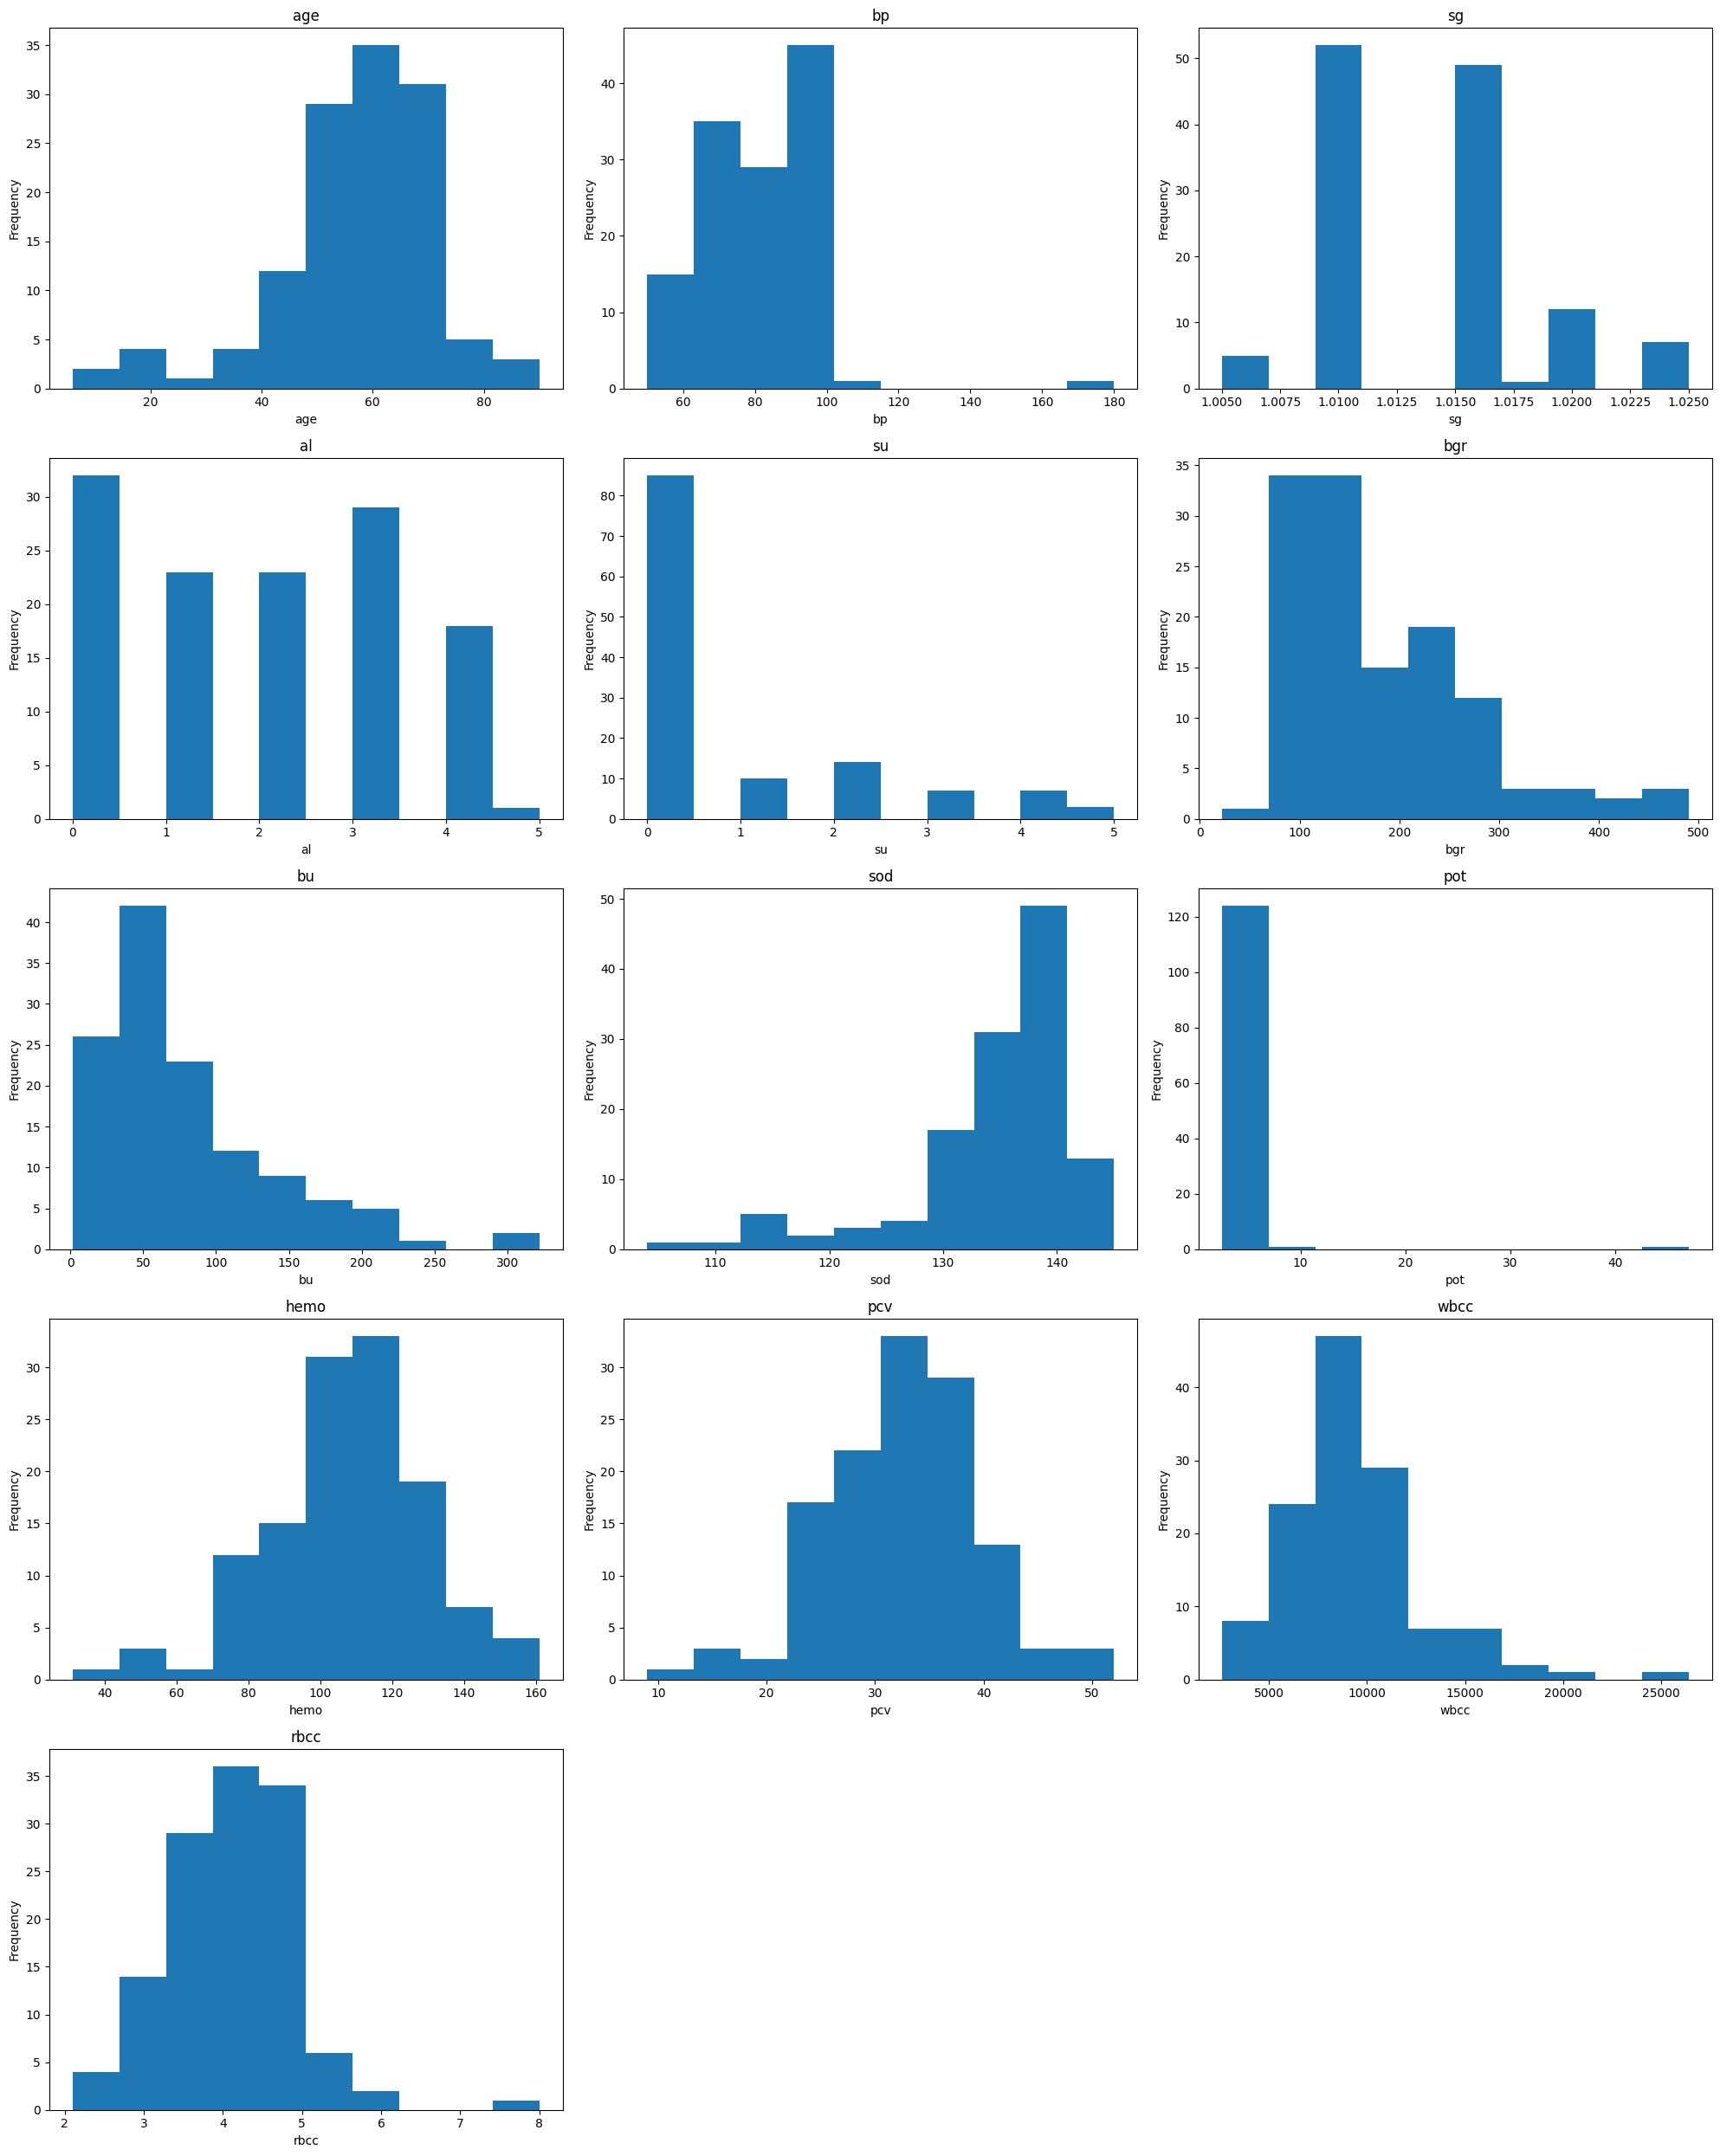

In [263]:
# Dataframe "a" histogrammi
plot_data(df_a)

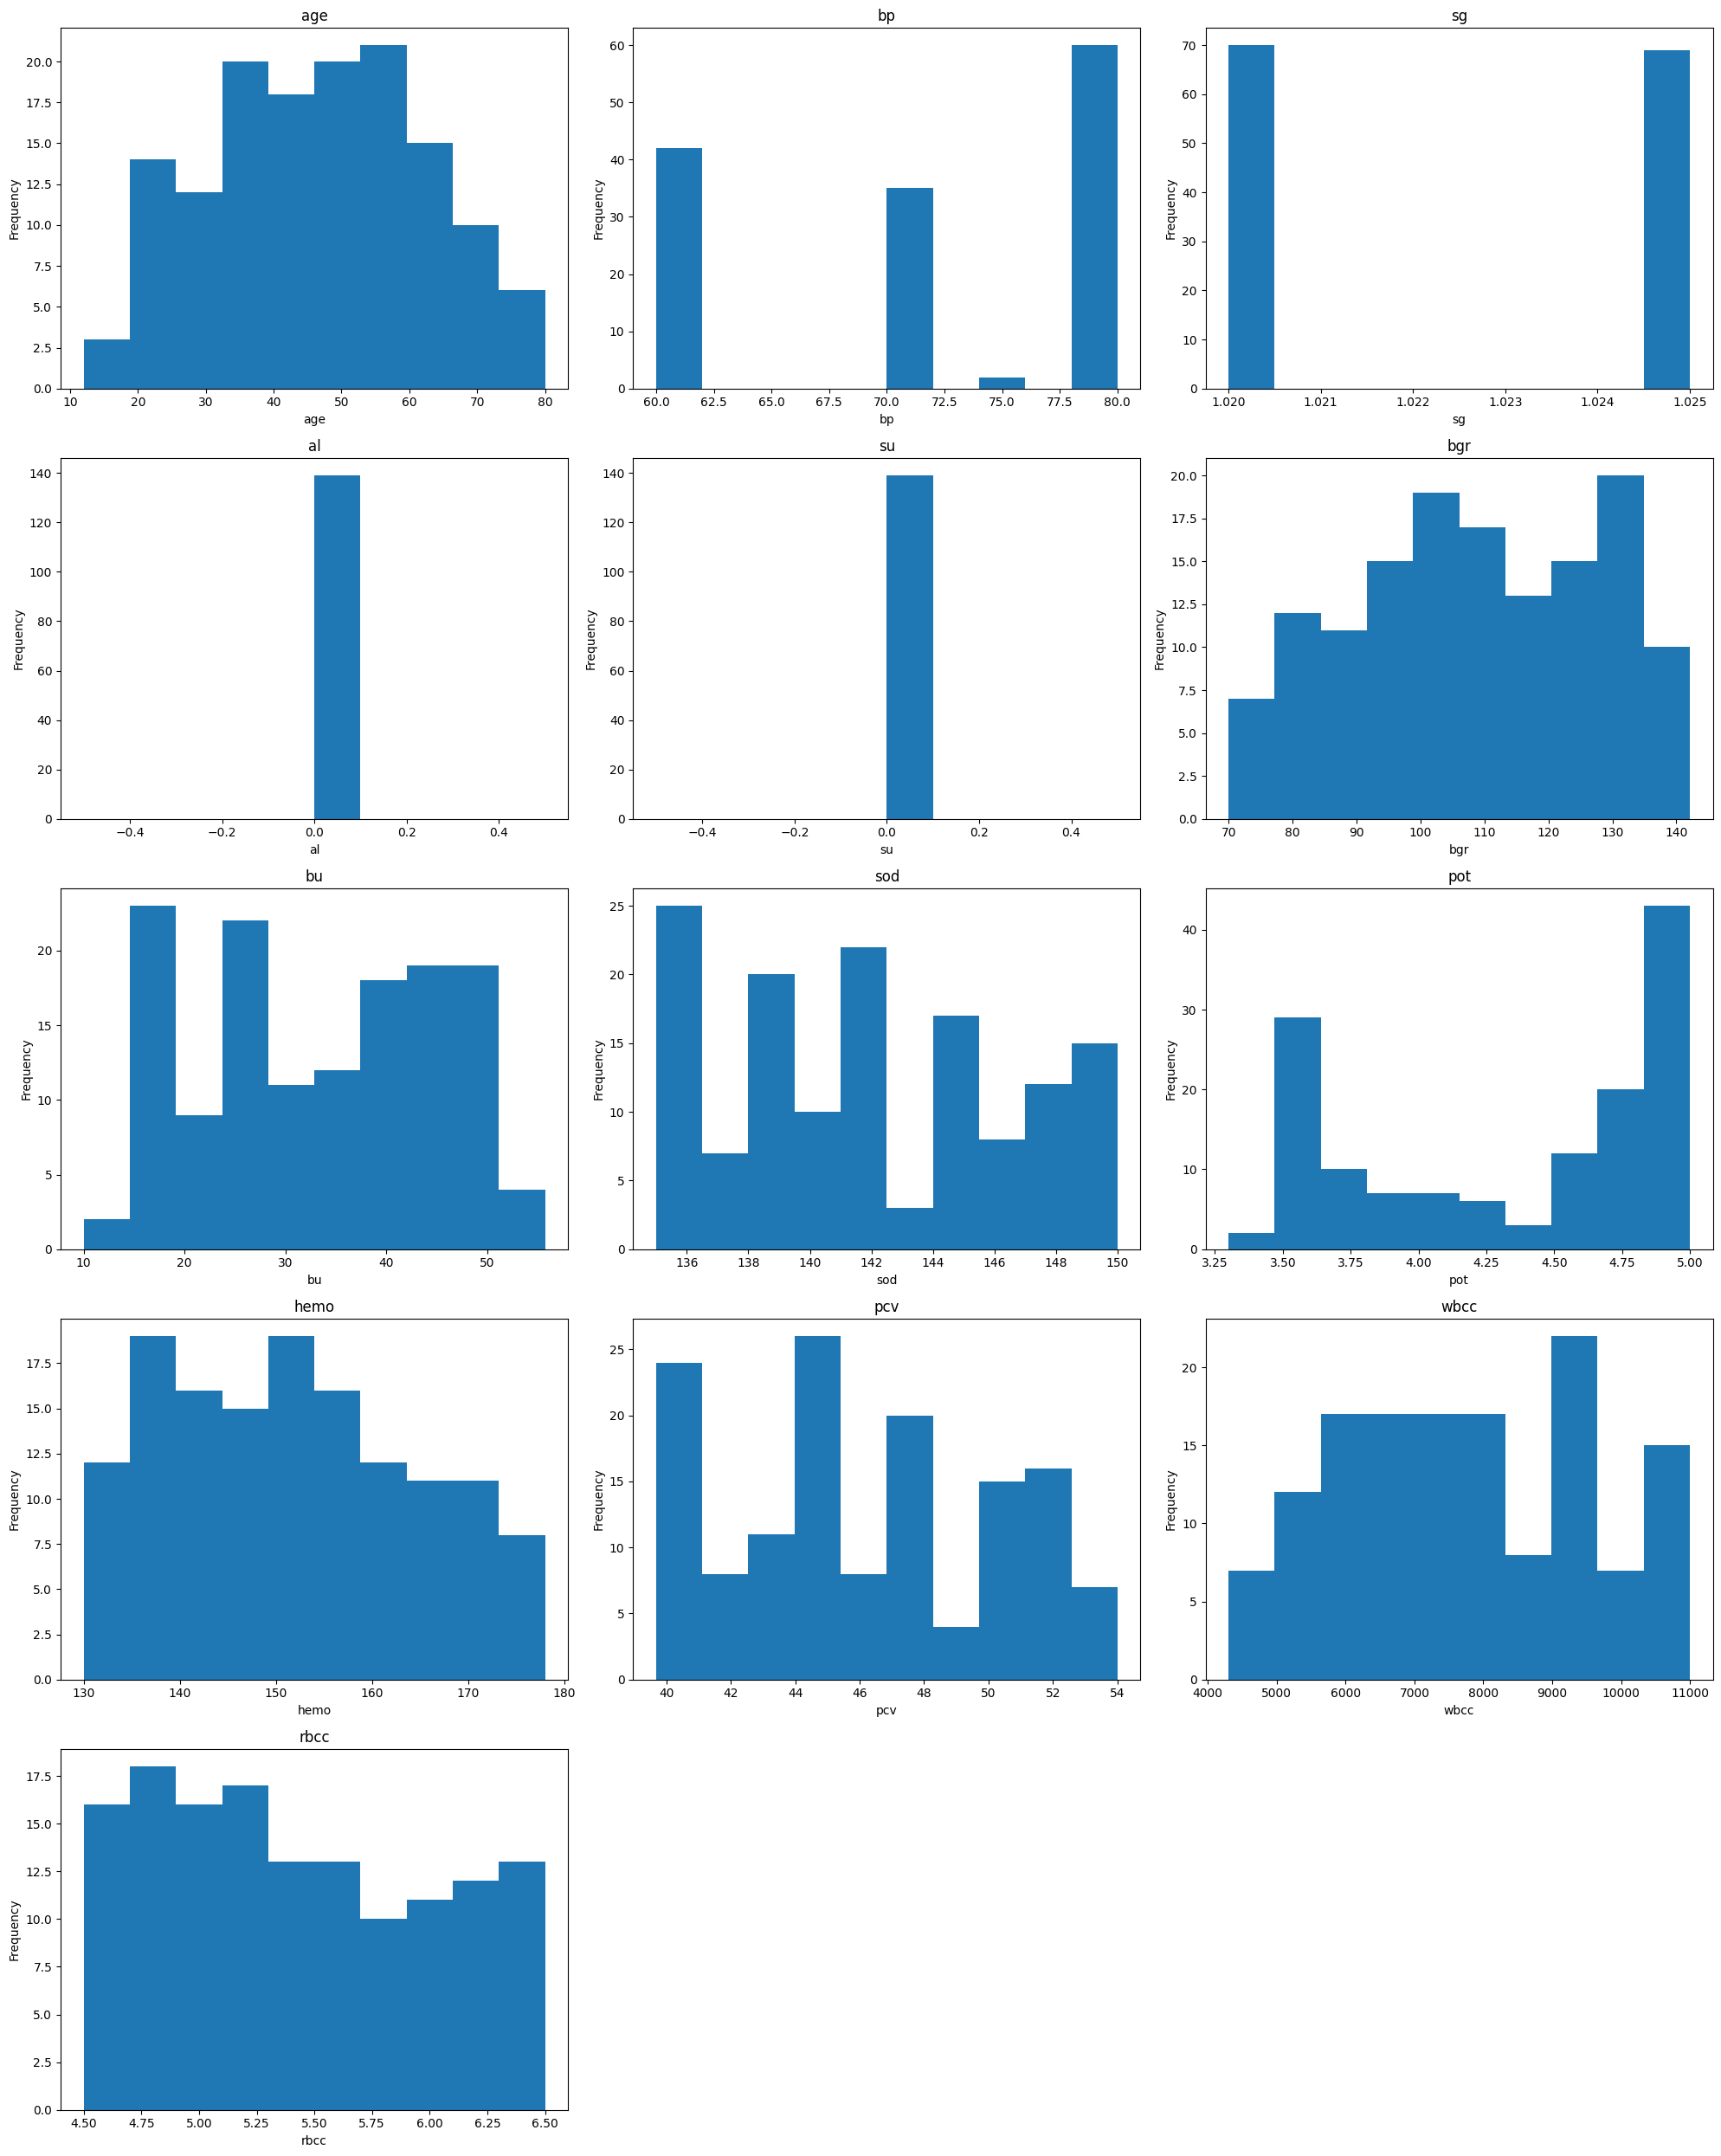

In [264]:
# Dataframe "c" histogrammi
plot_data(df_c)

In [265]:
# Funktio correlaatio matriksin tekoon ja heatmap

import matplotlib.pyplot as plt

def plot_correlation_matrix_matplotlib(df, title):
    numeric_cols = df.select_dtypes(include=['int', 'float']).columns
    corr = df[numeric_cols].corr()
    print(f"Correlation matrix for {title}:\n", corr)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(corr, cmap='coolwarm', interpolation='none')
    plt.colorbar()
    plt.xticks(range(len(corr)), corr.columns, rotation=90)
    plt.yticks(range(len(corr)), corr.columns)
    plt.title(f'Correlation matrix heatmap for {title}')
    plt.show()

Correlation matrix for Dataframe (a):
            age        bp        sg        al        su       bgr        bu  \
age   1.000000  0.066683 -0.008287 -0.015353  0.143637  0.201624  0.020184   
bp    0.066683  1.000000  0.103561  0.025275  0.182771  0.036711  0.067033   
sg   -0.008287  0.103561  1.000000 -0.070963 -0.025501 -0.076234 -0.042272   
al   -0.015353  0.025275 -0.070963  1.000000  0.115618  0.083630  0.426327   
su    0.143637  0.182771 -0.025501  0.115618  1.000000  0.665087 -0.056251   
bgr   0.201624  0.036711 -0.076234  0.083630  0.665087  1.000000 -0.050844   
bu    0.020184  0.067033 -0.042272  0.426327 -0.056251 -0.050844  1.000000   
sod  -0.025543  0.140154  0.132493 -0.216467  0.030066 -0.041318 -0.330705   
pot  -0.005175  0.066084  0.042630  0.170867  0.140845  0.019699  0.191448   
hemo  0.003760 -0.115363  0.107848 -0.378211  0.178660  0.158399 -0.608953   
pcv  -0.032217 -0.120094  0.098780 -0.336223  0.114814  0.111353 -0.569630   
wbcc  0.019126 -0.034912 

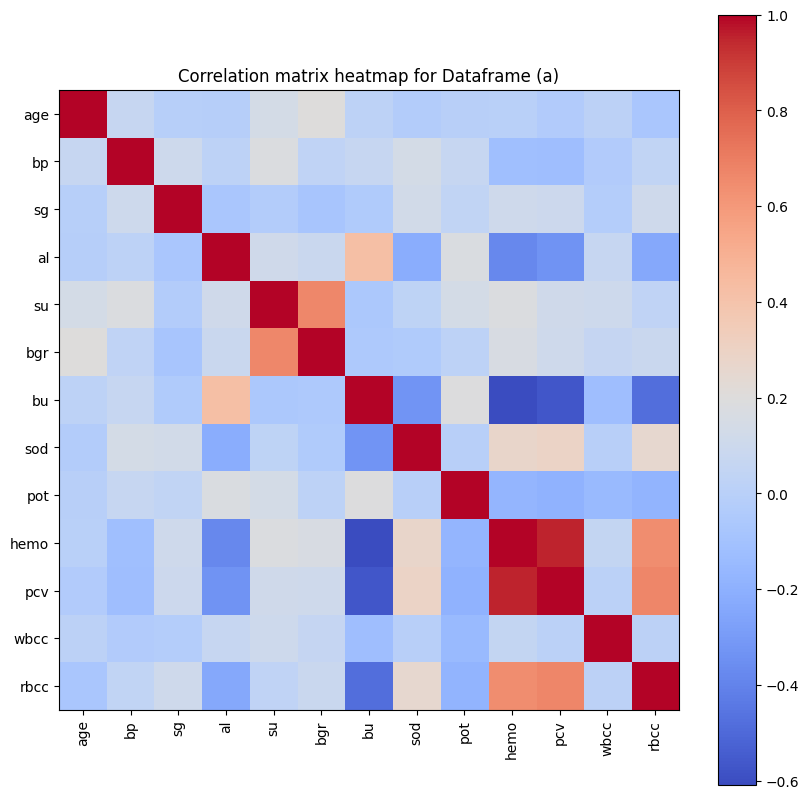

In [266]:
# Dataframe "a" correlation matrix ja heatmap
plot_correlation_matrix_matplotlib(df_a, "Dataframe (a)")

Correlation matrix for Dataframe (c):
            age        bp        sg  al  su       bgr        bu       sod  \
age   1.000000 -0.072757 -0.092814 NaN NaN  0.108365  0.078872  0.105948   
bp   -0.072757  1.000000  0.076135 NaN NaN -0.039596 -0.108135 -0.099754   
sg   -0.092814  0.076135  1.000000 NaN NaN -0.009829 -0.018737 -0.028067   
al         NaN       NaN       NaN NaN NaN       NaN       NaN       NaN   
su         NaN       NaN       NaN NaN NaN       NaN       NaN       NaN   
bgr   0.108365 -0.039596 -0.009829 NaN NaN  1.000000  0.023392 -0.020735   
bu    0.078872 -0.108135 -0.018737 NaN NaN  0.023392  1.000000 -0.046508   
sod   0.105948 -0.099754 -0.028067 NaN NaN -0.020735 -0.046508  1.000000   
pot  -0.091926 -0.057867  0.071163 NaN NaN  0.165981  0.036984  0.060360   
hemo  0.085749  0.143135  0.049480 NaN NaN -0.150540  0.061664 -0.045508   
pcv   0.006532 -0.016096  0.004397 NaN NaN -0.262185  0.058715 -0.003413   
wbcc  0.115814 -0.106402 -0.030798 NaN NaN -0.071

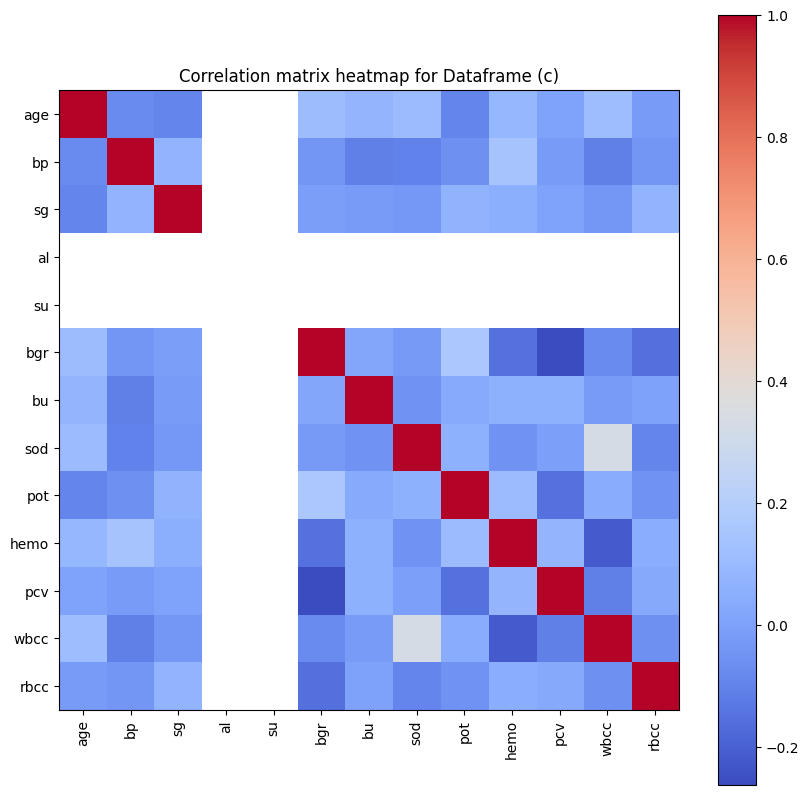

In [267]:
# Dataframe "c" correlation matrix ja heatmap
plot_correlation_matrix_matplotlib(df_c, "Dataframe (c)")